# Predict Missing Markers Trajectories

**References:**
- Federolf PA (2013) *A Novel Approach to Solve the “Missing Marker Problem” in Marker-Based Motion Analysis That Exploits the Segment Coordination Patterns in Multi-Limb Motion Data.* PLOS ONE 8(10): e78689. <a href="https://doi.org/10.1371/journal.pone.0078689">https://doi.org/10.1371/journal.pone.0078689</a>
- Gløersen Ø, Federolf P (2016) *Predicting Missing Marker Trajectories in Human Motion Data Using Marker Intercorrelations.* PLOS ONE 11(3): e0152616. <a href="https://doi.org/10.1371/journal.pone.0152616">https://doi.org/10.1371/journal.pone.0152616</a>

**Author:** Robbin Romijnders

Marker-based motion analysis generally suffers from loss of marker information, for example due to occlusion or marker detachment. Naive approaches to fillings gaps in the marker trajectories are based on linear or spline interpolation, however these are mainly suitable for gaps of short duration. In Federolf (2013) and Gløersen and Federolf (2016) a method was proposed that takes advantage of intercorrelations between neighboring markers. The MATLAB source code is available as the Supporting Information online:  
<a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0152616#sec018">https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0152616#sec018</a>.

Here, we have implemented the methods in Python for further use. We evaluated the methods, i.e. both reconstruction strategies as explained in Gløersen and Federolf (2016), by reconstructing the marker trajectories for randomly generated gaps in the trajectories from a reference dataset, i.e. *WalkL.mat* from Gløersen and Federolf (2016).

## Prerequisites

In [1]:
# Load libraries
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers
import os, re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

To evaluate the goodness of fit, or how well the reconstructed data represents the original data, we compute the Euclidean distance for each marker with missing data for each time step:
$$\begin{align}
d_{i}^{(m)} &= \sqrt{(x_{i}^{(m)} - x_{i}^{(m)})^{2} + (y_{i}^{(m)} - y_{i}^{(m)})^{2} + (z_{i}^{(m)} - z_{i}^{(m)})^{2}}\\
\bar{d}^{(m)} &= \frac{1}{N'} \sum_{i=1}^{N'} d_{i}^{(m)}
\end{align}$$

In [2]:
def mean_euclidean_distance(y, yhat):
    """Calculates the mean Euclidean distance between the original and reconstruct marker trajectory.

    Parameters
    ----------
    y : (N, 3) array_like)
        The original marker trajectory for N time steps of missing data.
    yhat : (N, 3) array_like
        The reconstructed marker trajectory.
    
    Returns
    -------
    _ : float
        The mean Euclidean distance.
    """

    # Compute the element-wise differences
    differences = ( yhat - y )

    # Take the squared values
    squared_differences = differences**2

    # Sum for each time step
    sum_squared_differences = np.sum(squared_differences, axis=1)

    # Take the square root
    distances = np.sqrt(sum_squared_differences)
    return np.mean(distances)

In [3]:
# Load data
PARENT_FOLDER = "./data/test"  # set parent folder
data_full = _load_file(os.path.join(PARENT_FOLDER, "WalkL.mat"))  # load original gap-free data

In [4]:
# Get a list of filenames
filenames = [fname for fname in os.listdir(PARENT_FOLDER) if re.match("WalkL_[0-9]{4}.mat", fname)]

## Processing

In [5]:
# Get shape of data
n_time_steps, n_channels = data_full.shape
n_markers = n_channels // 3
print(f"Number of time steps:\t {n_time_steps}")
print(f"Number of markers:\t {n_markers}")

Number of time steps:	 4300
Number of markers:	 37


In [6]:
# Initialize dictionary to store results
results = {}
for ix_marker in range(n_markers):
    results[ix_marker] = {"files": [], "distances": [], "gap_lengths": []}

In [25]:
# Set optional arguments
method = "R1"
weight_scale = 200
mm_weight = 0.02
distal_threshold = 0.5
min_cum_sv = 0.99
opts = {"method": method, "weight_scale": weight_scale, "mm_weight": mm_weight, "distal_threshold": distal_threshold, "min_cum_sv": min_cum_sv}

In [26]:
# Loop over the filenames
for (i, filename) in enumerate(filenames):
    
    # Get the data
    data_gaps = _load_file(os.path.join(PARENT_FOLDER, filename))

    # Reconstruct marker trajectories
    data_filled = _predict_missing_markers(data_gaps, **opts)
    if data_filled is None:
        continue

    # Evaluate
    ix_channels_with_gaps, = np.nonzero(np.any(np.isnan(data_gaps), axis=0))
    ix_markers_with_gaps = (ix_channels_with_gaps[2::3]//3)
    for ix_marker in ix_markers_with_gaps:
        # Find time steps with missing data
        ix_time_steps_with_gaps, = np.nonzero(np.any(np.isnan(data_gaps[:,ix_marker*3:ix_marker*3+3]), axis=1))

        # Get the mean Euclidean distance
        med = mean_euclidean_distance(data_full[ix_time_steps_with_gaps,3*ix_marker:3*ix_marker+3], data_filled[ix_time_steps_with_gaps,3*ix_marker:3*ix_marker+3])

        # Save to dictionary
        results[ix_marker]["files"].append(filename)
        results[ix_marker]["distances"].append(med)
        results[ix_marker]["gap_lengths"].append(len(ix_time_steps_with_gaps))


/home/robr/Code/pymocap/lib/preprocessing.py:207: UserWarning: For each time step there is at least one marker with missing data. Cannot perform reconstruction according to strategy R1.
  warnings.warn("For each time step there is at least one marker with missing data. Cannot perform reconstruction according to strategy R1.")


## Visualize

In [27]:
ix_random_file = np.random.choice(len(filenames), 1, replace=False)[0]
print(f"{ix_random_file:d}: {filenames[ix_random_file]:s}")

85: WalkL_0002.mat


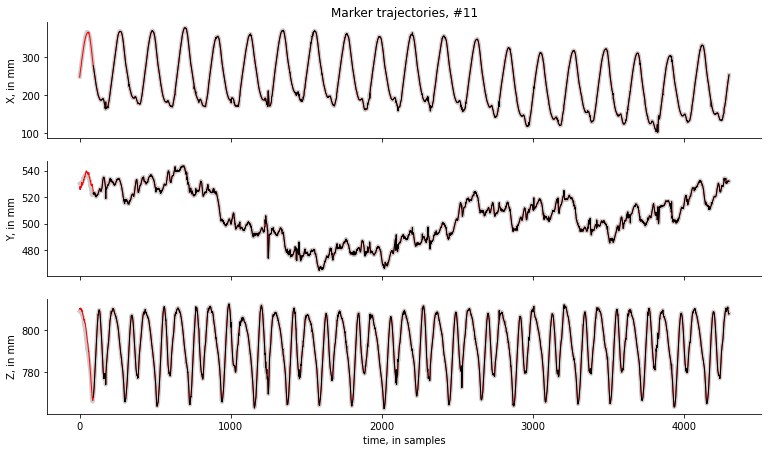

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt

dims = ["X", "Y", "Z"]
n_dims = len(dims)  # number of dimensions, i.e., 3D

fig, axs = plt.subplots(n_dims, 1, figsize=(12.8, 7.2), sharex=True)

data_gaps = _load_file(os.path.join(PARENT_FOLDER, filenames[ix_random_file]))

# Fill gaps
data_filled = _predict_missing_markers(data_gaps, **opts)

# Find channels/markers with missing data
ix_channels_with_gaps, = np.nonzero(np.any(np.isnan(data_gaps), axis=0))
ix_markers_with_gaps = (ix_channels_with_gaps[2::3]//3)

# Pick a random marker with missing data
ix_random_marker = ix_markers_with_gaps[np.random.choice(len(ix_markers_with_gaps), 1, replace=False)[0]]

# Find the time steps with missing data
ix_time_steps_with_gaps, = np.nonzero(np.any(np.isnan(data_gaps[:,ix_random_marker*3:ix_random_marker*3+3]), axis=1))

# Plot data
for ix_dim in range(n_dims):
    axs[ix_dim].plot(np.arange(data_full.shape[0]), data_full[:,ix_random_marker*3+ix_dim], '-', lw=4, c=(0, 0, 0, 0.2))
    axs[ix_dim].plot(np.arange(data_filled.shape[0]), data_filled[:,ix_random_marker*3+ix_dim], '-', lw=1, c=(1, 0, 0))
    axs[ix_dim].plot(np.arange(data_gaps.shape[0]), data_gaps[:,ix_random_marker*3+ix_dim], '-', lw=1, c=(0, 0, 0))
    axs[ix_dim].set_ylabel(f"{dims[ix_dim]:s}, in mm")
axs[ix_dim].set_xlabel("time, in samples")
axs[0].set_title(f"Marker trajectories, #{ix_random_marker:d}")
plt.show()   
    

## Evaluation

Let us print the Euclidean distances and the corresponding gap length for each of the markers. Note that these results are the averaged distances over 100 trials with missing marker data, but it need not the be that the marker has gaps in each trial.

In [29]:
print(f"{'marker':s}: {'Eucl dist (mm)':>18s}, {'gap length (frames)':>22s}")
print(f"{'mean':>16s}  [{'mi':>2s}; {'ma':>2s}], {'mean':>8s}  [{'mi':>4s}; {'ma':>4s}]")
print(f"{50*'-':s}")
for k in results.keys():
    mn, mi, ma = np.mean(results[k]["distances"]), np.min(results[k]["distances"]), np.max(results[k]["distances"])
    lng, lngi, lnga = np.mean(results[k]["gap_lengths"]), np.min(results[k]["gap_lengths"]), np.max(results[k]["gap_lengths"])
    print(f"{k:>6d}: {mn:>8.0f}  [{mi:>2.0f}; {ma:>2.0f}], {lng:>8.0f}  [{lngi:>4.0f}; {lnga:>4.0f}]")

marker:     Eucl dist (mm),    gap length (frames)
            mean  [mi; ma],     mean  [  mi;   ma]
--------------------------------------------------
     0:       22  [ 4; 430],      335  [  24; 1026]
     1:       20  [ 1; 366],      372  [  27; 1098]
     2:       21  [ 2; 322],      404  [  35; 1363]
     3:       12  [ 1; 179],      365  [  23; 1439]
     4:       17  [ 2; 303],      308  [  20;  777]
     5:       13  [ 2; 156],      355  [   2; 1052]
     6:       29  [ 5; 363],      423  [  28; 1503]
     7:       19  [ 1; 177],      343  [  10; 1229]
     8:       22  [ 2; 178],      387  [  24; 1330]
     9:       13  [ 2; 132],      345  [  14; 1246]
    10:       16  [ 3; 171],      342  [  37; 1277]
    11:       13  [ 3; 111],      387  [  45; 1126]
    12:       13  [ 2; 635],      372  [  24; 1359]
    13:        5  [ 2; 69],      335  [  26; 1249]
    14:        5  [ 1; 75],      365  [  36; 1091]
    15:        6  [ 1; 69],      349  [  41; 1230]
    16:        5  